# Face Detection 
----
----
## Overview
----
**In this project we'll make face detection model,which will detect any face present in cam or any test image.**

**To build this model we need to use classification(face is present or not in input frame) for detecting and regression(plotting where face is present) for labeling.**

----

In [2]:
import os
import time
import uuid
import cv2

In [2]:
import pandas as pd

## Collecting Data
----
----
**We'll create our own data by capturing some images using cv2 and then use albumentations library for multiplying our images into large dataset.**

----

In [3]:
image_path = os.path.join('data','Images')

In [16]:
cap = cv2.VideoCapture(0)
for img in range(10):
    print("Collecting Image {}".format(img))
    ret, frame = cap.read()
    imgname = os.path.join(image_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(1)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Label Data
----
----
**After collecting data we need to label those images and plot rectangles on face.**

----

In [ ]:
pip install labelme

## Review Data and Build Image Loading Function
----
----


In [8]:
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import numpy as np

In [8]:
tf.config.threading.set_intra_op_parallelism_threads(10)
tf.config.threading.set_inter_op_parallelism_threads(4)

In [10]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [11]:
images.as_numpy_iterator().next()

b'data\\images\\6f24c046-e515-11ef-b022-30894a9ef470.jpg'

In [12]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [30]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Manually Split Data into Train Validation Test 
----
----
**After spliting images into train,val and test, Move labeled matching json files.**

----

In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

## Apply Image Augmentation on Images and Labels using Albumentations
----
----

In [ ]:
pip install albumentations

In [33]:
import albumentations as alb

C:\Users\dhali\Projects\Face Detection\facedect\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [34]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [37]:
img = cv2.imread(os.path.join('data','train','images','2e3e02b8-e510-11ef-b102-30894a9ef470.jpg'))

In [38]:
with open(os.path.join('data','train','labels','2e3e02b8-e510-11ef-b102-30894a9ef470.json')) as f:
    label = json.load(f)

In [39]:
label['shapes'][0]['points']

[[261.32653061224494, 207.09183673469386],
 [391.42857142857144, 339.7448979591837]]

## Extract Coordinates and Rescale to Match Image Resolution
----
----

In [40]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [41]:
coords # [xmin, ymin , xmax, ymax]

[261.32653061224494, 207.09183673469386, 391.42857142857144, 339.7448979591837]

In [42]:
coords = list(np.divide(coords, [640,480,640,480]))
# normalized to feed image to augmentor

In [43]:
coords

[np.float64(0.40832270408163274),
 np.float64(0.4314413265306122),
 np.float64(0.6116071428571429),
 np.float64(0.7078018707482994)]

In [44]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## Build and Run Augmentation Pipeline
----
----

In [46]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.10538903 0.60682398 0.         0.88586819 0.        ].
x_max is less than or equal to x_min for bbox [0.18431123 0.53454506 0.         0.88792729 0.        ].


##  Load Augmented Images to Tensorflow Dataset
----
----

In [47]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [48]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [49]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [50]:
train_images.as_numpy_iterator().next()

array([[[0.13468137, 0.14056373, 0.18412991],
        [0.13799019, 0.1288603 , 0.18762255],
        [0.27199754, 0.2641544 , 0.3166054 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.13976716, 0.13584559, 0.19393383],
        [0.14773284, 0.1360294 , 0.20036764],
        [0.19319853, 0.19957107, 0.25202206],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.17285539, 0.17610294, 0.22916667],
        [0.12634803, 0.11164216, 0.1661152 ],
        [0.20183824, 0.22212009, 0.28480393],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

## Build Label Loading Function and Load Labels to Tensorflow Dataset
----
----

In [51]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [52]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json',shuffle=False)
train_labels = train_labels.map(lambda x : tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [54]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [56]:
len(train_labels),len(train_images),len(val_images),len(val_labels),len(test_images),len(test_labels)

(4080, 4080, 840, 840, 360, 360)

## Combine Label and Image Samples for Final Datasets
----
----

In [59]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(16)
train = train.prefetch(8)

In [60]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1700)
test = test.batch(8)
test = test.prefetch(4)

In [61]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1700)
val = val.batch(8)
val = val.prefetch(4)

In [62]:
data_sample = train.as_numpy_iterator()

In [63]:
res = data_sample.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,10))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Building Model
----
----
**We'll use VGG16 arcitecture to build our model.**

----

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [66]:
vgg = VGG16(include_top=False)

In [67]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [69]:
facetracker = build_model()

In [70]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
X, y = train.as_numpy_iterator().next()

In [72]:
X.shape

(16, 120, 120, 3)

In [73]:
print(y[0])

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]


In [74]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [75]:
classes, coords

(array([[0.3206107 ],
        [0.34465122],
        [0.24204339],
        [0.35935175],
        [0.4094143 ],
        [0.3466896 ],
        [0.30512625],
        [0.45004475],
        [0.40788877],
        [0.414861  ],
        [0.41407752],
        [0.3504561 ],
        [0.216828  ],
        [0.37418815],
        [0.33996058],
        [0.33312675]], dtype=float32),
 array([[0.5551126 , 0.60156405, 0.60102963, 0.5768244 ],
        [0.5699768 , 0.4950915 , 0.62562853, 0.45996308],
        [0.5459776 , 0.49649853, 0.5566832 , 0.5622225 ],
        [0.46839443, 0.5093001 , 0.47995126, 0.6467134 ],
        [0.48173568, 0.50973296, 0.551332  , 0.5623455 ],
        [0.59089935, 0.50419676, 0.51561546, 0.53743833],
        [0.47949204, 0.5813803 , 0.48923567, 0.6177361 ],
        [0.49602604, 0.51498085, 0.57186663, 0.5773153 ],
        [0.56636894, 0.47883525, 0.55640936, 0.48021644],
        [0.60690963, 0.4979857 , 0.55468035, 0.47454044],
        [0.4753182 , 0.5353384 , 0.5369483 , 0.6474

# Define Losses and Optimizers
----
----
**Create Localization Loss and Classification Loss**

----
----

In [76]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [77]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

C:\Users\dhali\Projects\Face Detection\facedect\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [78]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [79]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [80]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.631464004516602>

In [81]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0197350978851318>

# Train Neural Network
----
----


In [82]:
class FaceTracker(Model): 
    def __init__(self, tracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(tf.reshape(y[0], (-1, 1)), classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(tf.reshape(y[0], (-1, 1)), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [83]:
model = FaceTracker(facetracker)

In [84]:
model.compile(opt,classloss,regressloss)

# Train Model
----
----

In [85]:
logdir='logs'

In [86]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [104]:
model.fit(train, epochs=40,validation_data=val, callbacks=[earltstopping])

Epoch 1/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1193s 4s/step - class_loss: 0.0141 - regress_loss: 0.0792 - total_loss: 0.0863 - val_class_loss: 2.6251e-04 - val_regress_loss: 0.0111 - val_total_loss: 0.0112
Epoch 2/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 3882s 15s/step - class_loss: 0.0043 - regress_loss: 0.0285 - total_loss: 0.0306 - val_class_loss: 5.9954e-05 - val_regress_loss: 0.0073 - val_total_loss: 0.0073
Epoch 3/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - class_loss: 0.0200 - regress_loss: 0.1072 - total_loss: 0.1171 - val_class_loss: 1.7645e-05 - val_regress_loss: 0.0399 - val_total_loss: 0.0400
Epoch 4/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 787s 3s/step - class_loss: 0.0074 - regress_loss: 0.0508 - total_loss: 0.0545 - val_class_loss: 1.6332e-04 - val_regress_loss: 0.0195 - val_total_loss: 0.0195
Epoch 5/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 785s 3s/step - class_loss: 0.0097 - regress_loss: 0.0457 - total_loss: 0.0505 - val_class_loss: 0.0070 - val_regress_loss: 0.0138 - val_total_loss: 0.0174
Epoch 

# Save Model
----
----

In [4]:
from tensorflow.keras.models import load_model

In [115]:
facetracker.save('facetracker.keras')

In [5]:
facetracker = load_model('facetracker.keras')

# Plot Model's Performance
----
----

In [105]:
new_losses = pd.DataFrame(model.history.history)

In [89]:
data_losses = pd.DataFrame(model.history.history)

In [92]:
data_losses

,class_loss,regress_loss,total_loss,val_class_loss,val_regress_loss,val_total_loss
0,0.007000,0.180057,0.183557,0.000829,0.033352,0.033767
1,0.013570,0.175061,0.181846,0.004786,0.030936,0.033329
2,0.001103,0.030586,0.031137,0.000086,0.019844,0.019887
3,0.001921,0.062940,0.063900,0.002164,0.025400,0.026482
4,0.000369,0.013778,0.013962,0.000832,0.007738,0.008154
5,0.000570,0.017992,0.018277,0.002051,0.010135,0.011160
6,0.149275,0.651583,0.726221,0.000276,0.031206,0.031344


<Axes: >

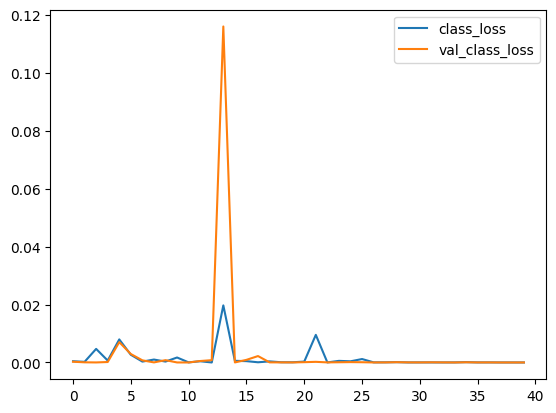

In [106]:
new_losses[['class_loss','val_class_loss']].plot()

<Axes: >

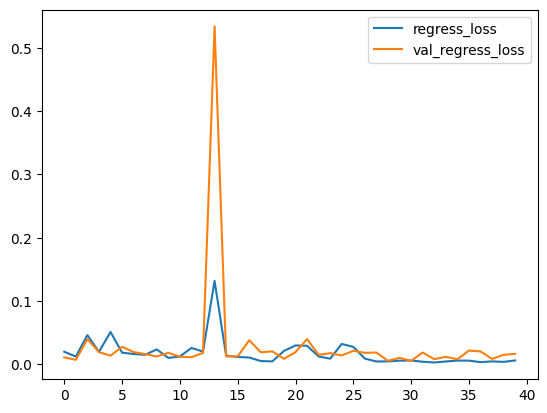

In [107]:
new_losses[['regress_loss','val_regress_loss']].plot()

<Axes: >

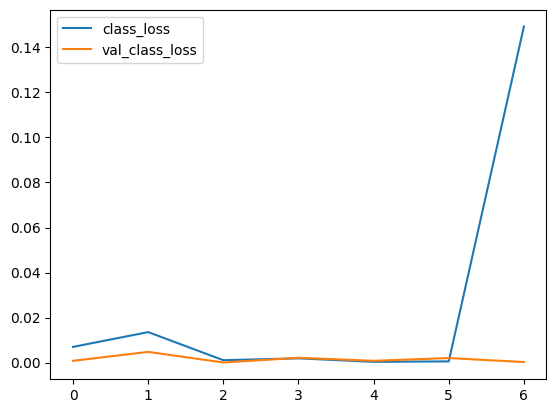

In [91]:
data_losses[['class_loss','val_class_loss']].plot()

<Axes: >

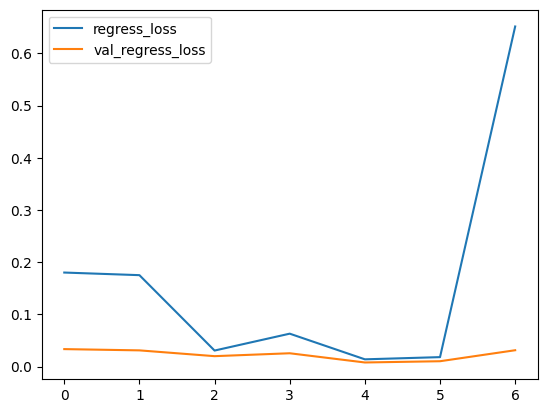

In [93]:
data_losses[['regress_loss','val_regress_loss']].plot()

# Make Predictions
----
----
**Make Predictions on Test Data**

----
----

In [108]:
test_data = test.as_numpy_iterator()

In [109]:
test_sample = test_data.next()

In [110]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Real Time Detection
----
----

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()